We are going to find probability density function (PDF) $\rho(x, t)$ for spatial variable $x \in R^d$ (below for simplicity we consider the case $d=2$) which is solution of the SDE with Brownian motion $\beta$ (of dimension $q=d=2$)
$$
dx = f(x, t) \, dt + S(x, t) \, d\beta,
\quad
d\beta \, d\beta^{\top} = Q dt,
\quad
x(0) = x_0.
$$

It can be shown that PDF is the solution of a Fokker-Planck equation
$$
\frac{\partial \rho(x, t)}{\partial t} =
    - \sum_{i=1}^d
        \frac{\partial}{\partial x_i}
        \left[ f_i(x, t) \rho(x, t) \right]
    + \sum_{i=1}^d \sum_{j=1}^d
        \frac{\partial^2}{\partial x_i \partial x_j}
        \left[ D_{ij}(x, t) \rho(x, t) \right],
\quad
\rho(x, 0) = \rho_0(x),
$$
where
$$
D(x, t) = \frac{1}{2} S(x, t) Q S^{\top}(x, t).
$$

Let $S(x, t) = I$, $Q = 2I$ (hence $D(x, t) = I$), then we should solve

$$
dx = f(x, t) \, dt + d\beta,
\quad
x(0) = x_0.
$$

$$
\frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
\quad
\rho(x, 0) = \rho_0(x).
$$

Let apply 1st order splitting scheme on $k$-th time step $kh$ (with known from previous step $\rho_{k}$)
$$
\frac{\partial v}{\partial t} = \Delta v,
\quad
v_{k} = v(x(t_{k}), t_{k}) = \rho_{k} = \rho(x(t_{k}), t_{k}),
\quad
(1)
$$
$$
\frac{\partial w}{\partial t} = - div \left[ f(x, t) w \right],
\quad
w_{k} = v_{k+1},
\quad
(2)
$$
then we can approximate $\rho_{k+1} = w_{k+1}$.

To solve equation (1) we perform discretization of spatial variable on uniform grid with the step size $l$.
Then
$$
\Delta = I \otimes L + L \otimes I,
\quad
L = \frac{1}{l^2} tridiag \left[ 1, -2, 1 \right],
$$
and solution of (1) has the form
$$
v_{k+1} = e^{h \left( I \otimes L + L \otimes I \right)} \rho_{k},
$$
or
$$
v_{k+1} = e^h \left( e^L \otimes e^L \right) \rho_{k},
$$

Equation (2) looks like equation for PDF $w$ of solution of ODE without noise
$$
dx = f(x, t) \, dt
\quad
x(0) = x_0.
$$

According to standard Euler scheme
$$
x_{k+1} = x_{k} + h f(x_{k}, t_{k}),
\quad (3)
$$
and using PDF transformation formula, we obtain
$$
w_{k+1} = \frac{w_{k}}{det \left(I + h \frac{\partial f}{\partial x} \right)} \approx
    w_{k} \left( 1 - h \cdot tr \left( \frac{\partial f}{\partial x} \right) \right).
\quad (4)
$$

Let consider time step $k$ and suppose that $x_{k} = x_0 \in R^{d \times n}$ be array of points of uniform spatial grid $X$ with $n^d$ points and limits $x_{min}$, $x_{max}$ and $w_{k}$ is defined on the same regular grid $X$.
Formula (4) provide us with values $w_{k+1}$ on irregular points $x_{k+1}$ according to formula (3).
Since on each time step we are interested on $w$ values on regular grid, we should interpolate $w_{k}$ values as $\widehat{w}_{k}$ on points 
$$
\widehat{x}_{k} = x_0 - h f(x_{k}, t_{k}),
\quad (5)
$$
then formula (4) will give us values of $w_{k+1}$ on original regular grid $X$.

$$
w_{k+1} =
    E_{x_0 \rightarrow \widehat{x}_{k}} \left[w_{k} \right]
    \left( 1 - h \cdot tr \left( \frac{\partial f}{\partial x} \right) \right).
\quad (6)
$$

Finally we obtain for the PDF value $\rho_{k+1}$ on time step $k+1$ ($k=0, 1, \ldots$)
$$
\rho_{k+1} = 
    e^h
    \left( e^L \otimes e^L \right)
    E_{x_0 \rightarrow \widehat{x}_{k}} \left[ \rho_{k} \right] \cdot
    \left( 1 - h \cdot tr \left( \frac{\partial f}{\partial x} (x_{k}, t_{k}) \right) \right),
$$
with known
$$
\rho_0 = \rho(x, 0) = \rho_0(x).
$$

In [1]:
import sys
import time

import numpy as np
from numpy import kron as kron

import scipy.sparse as sp
from scipy.linalg import expm as expm
from scipy.interpolate import RectBivariateSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import HTML

sys.path.append('./../lib')
from intertrain import Intertrain

In [2]:
# SDE parameters
# f = A x
# df / dx = A

A = np.array([
    [1.0, 0.0],
    [1.0, 1.0],
])

In [3]:
# Time grid

t_min = 0.
t_max = 1.
t_poi = 100 # including t_min and t_max (>= 2)

m = t_poi
h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(t_min, t_max, t_poi)

In [4]:
# Spatial grid

x_min = -3.
x_max = +3.
x_poi = 8 # including x_min and x_max (>= 2)

n = x_poi
l = (x_max - x_min) / x_poi

x1d = np.linspace(x_min, x_max, x_poi)
X1, X2 = np.meshgrid(x1d, x1d)
X = np.array([X1, X2]).reshape((2, -1))

In [5]:
# Initial condition for x

x0 = X.copy()

In [6]:
# Initial condition for r

r0 = np.exp(-0.5 * np.diag(x0.T@x0)).reshape(-1, 1)

In [7]:
# Special matrices

I = np.eye(n)
L = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() / l / l
L = L.toarray()
Z = expm(L)
Z = np.exp(h) * kron(Z, Z)

In [8]:
def interpolate(r0, x0, x):
    fun = RectBivariateSpline(x1d, x1d, r0.reshape((n, n)))
    r = fun(*x, grid=False)
    return r

In [9]:
def step(x0, r0):
    f = A@x0       # f(x, t)
    g = A          # d f(x, t) / dx
    x = x0 + h * f
    r = (1. - h * np.trace(g)) * Z@interpolate(r0, x0, x)

    return (x, r)

In [10]:
def calc():
    x = x0.copy()
    r = r0.copy()

    X_list = [x]
    R_list = [r]
    
    for _ in range(t_poi-1):
        x, r = step(x, r)
        X_list.append(x)
        R_list.append(r)
    
    return (X_list, R_list)

In [11]:
# Run caclulations

X_list, R_list = calc()

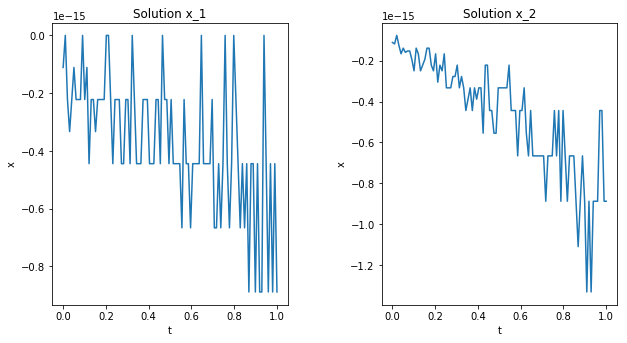

In [12]:
# Plot solution x for each dimension on separate plot vs time

fig = plt.figure(figsize=(8, 4))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1], height_ratios=[1]
)

ax = fig.add_subplot(gs[0, 0])
ax.plot(T, [np.mean(X[0, :]) for X in X_list], label='x_1')
ax.set_title('Solution x_1')
ax.set_xlabel('t')
ax.set_ylabel('x')

ax = fig.add_subplot(gs[0, 1])
ax.plot(T, [np.mean(X[1, :]) for X in X_list], label='x_2')
ax.set_title('Solution x_2')
ax.set_xlabel('t')
ax.set_ylabel('x')

plt.show()

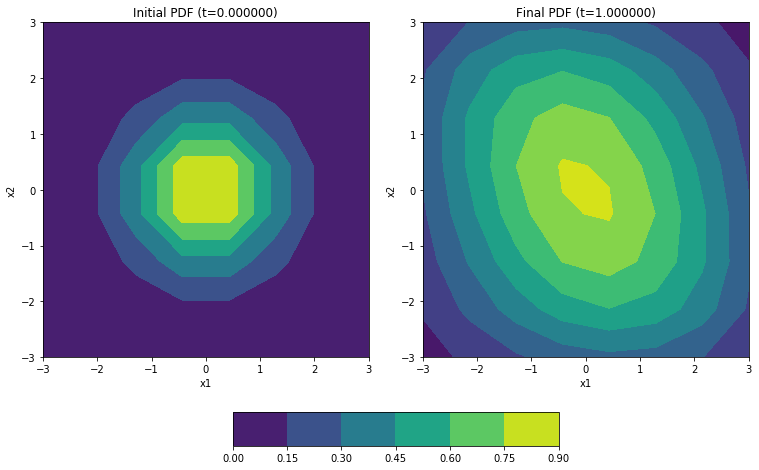

In [13]:
# Plot distribution (initial and final) on spatial grid

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(
    ncols=4, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1, 1, 1], height_ratios=[10, 1]
)

ax = fig.add_subplot(gs[0, :2])
ct1 = ax.contourf(X1, X2, R_list[0].reshape((x_poi, x_poi)))
ax.set_title('Initial PDF (t=%f)'%t_min)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[0, 2:])
ct2 = ax.contourf(X1, X2, R_list[-1].reshape((x_poi, x_poi)))
ax.set_title('Final PDF (t=%f)'%t_max)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[1, 1:3])
cb = plt.colorbar(ct1, cax=ax, orientation='horizontal')
# cb.add_lines(ct2)

plt.show()

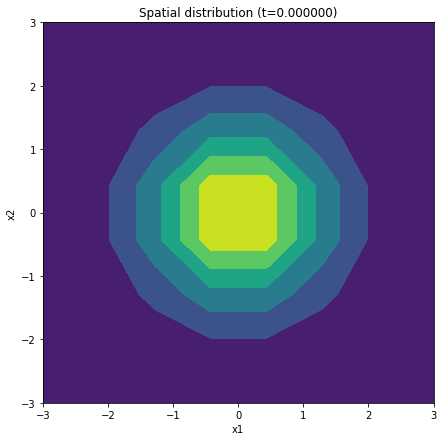

In [14]:
# Build animation for distribution vs time

# Interval between frames
delt = 50 

# Path to ffmpeg executable
plt.rcParams['animation.ffmpeg_path'] = './../tmp/ffmpeg'

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

def run(i):
    t = T[i]
    r = R_list[i].reshape((x_poi, x_poi))

    ax.clear()
    ax.set_title('Spatial distribution (t=%f)'%t)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ct = ax.contourf(X1, X2, r)
    return (ct,)

anim = animation.FuncAnimation(fig, run, frames=len(T), interval=delt, blit=False)
HTML(anim.to_html5_video())